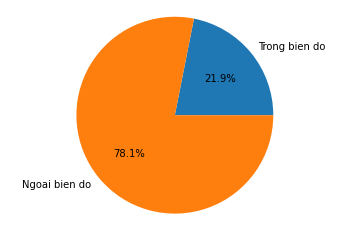

In [11]:
from myenv.models.candlestick import Candlestick
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


candlestick = Candlestick()

bitcoin_prices = candlestick.to_df()

bitcoin_prices.describe()

data = [0]

for index, row in bitcoin_prices.iterrows():
    if index < 1 or index > bitcoin_prices['close'].count() - 1:
        continue

    dkm = 0
    if row['low'] < bitcoin_prices.iloc[index - 1]['low'] or row['high'] > bitcoin_prices.iloc[index - 1]['high']:
        dkm = 1

    data.append(dkm)

bitcoin_prices['dkm'] = data
group = bitcoin_prices.groupby('dkm').dkm.count()

group.loc[0]

labels = 'Trong bien do', 'Ngoai bien do'
sizes = [group.loc[0], group.loc[1]]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

